# Setup

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import cv2
from scipy.signal import resample
from scenedetect import detect, AdaptiveDetector, split_video_ffmpeg # https://www.scenedetect.com/download/

import variables as var

In [2]:
train_df = pd.read_csv("data/SnapUGC/train_out.txt", sep='\t')
train_df['Set'] = 'train'

test_df = pd.read_csv("data/SnapUGC/test_out.txt", sep='\t')
test_df['Set'] = 'test'

df = pd.concat([train_df, test_df])

display(df)
len(train_df), len(test_df), len(df)

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train
4,20c0ea87f1d3d7ce1f5480a8d748e48e,9.976633,0,0,NaN,NaN,https://bolt-gcdn.sc-cdn.net/y/OWVh8dymJFW6fVo...,train
...,...,...,...,...,...,...,...,...
15635,4c358a2ab313460ae13f91f5bd559d96,6.773433,44551,131081,Name a better penalty takereyes womensworldcu...,I should be taking penalties at the women’s Wo...,https://bolt-gcdn.sc-cdn.net/y/T5n7jvYxN8sitP0...,test
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test
15638,5f3908c3e4298ea00a6e3f33bea23a46,14.933333,2139,131097,gothgirl plussize thickwomen chubby curvy...,NaN,https://cf-st.sc-cdn.net/d/DeVWxuTXeZ42TVwHmDf...,test


(113810, 15640, 129450)

# Only select video with duration 10-60s

In [3]:
df = df[(df['Video_len'] >= 10) & (df['Video_len'] <= 60)]
df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train
6,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train
...,...,...,...,...,...,...,...,...
15633,62c9e70d1a124570a7633ae2956621c3,23.300000,1815,131039,Thats Hot. Bbw bbwcontent bbwgoddess bbwqu...,NaN,https://cf-st.sc-cdn.net/d/VYqFXqDsbDfb8BwSL3o...,test
15634,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test


# Normalize order to 0-1

In [4]:
mmscl = MinMaxScaler()

df['ECR'] = mmscl.fit_transform(df['order of ECR'].to_numpy()[:, np.newaxis])[:, 0]
df['NAWP'] = mmscl.fit_transform(df['order of NAWP'].to_numpy()[:, np.newaxis])[:, 0]
df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train,0.000000,0.000000
6,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
15633,62c9e70d1a124570a7633ae2956621c3,23.300000,1815,131039,Thats Hot. Bbw bbwcontent bbwgoddess bbwqu...,NaN,https://cf-st.sc-cdn.net/d/VYqFXqDsbDfb8BwSL3o...,test,0.014205,0.999535
15634,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test,0.371187,0.999596
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test,0.275392,0.999893
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test,0.012459,0.999924


# Select filtered videos

In [5]:
train_videos = glob.glob(os.path.join(var.TRAIN_VIDEOS_PATH, "*.mp4"))
test_videos = glob.glob(os.path.join(var.TEST_VIDEOS_PATH, "*.mp4"))

len(train_videos), len(test_videos)

(107506, 14785)

In [6]:
train_videos = pd.DataFrame({"Id": [s[s.rfind("/")+1:s.rfind(".mp4")] for s in train_videos],
                             "Video": train_videos,
                             "Set": "train"})
test_videos = pd.DataFrame({"Id": [s[s.rfind("/")+1:s.rfind(".mp4")] for s in test_videos],
                             "Video": test_videos,
                             "Set": "test"})

videos_df = pd.concat([train_videos, test_videos])
videos_df

,Id,Video,Set
0,00002d8ca92d43d359dc31a5e7e31fcc,/mnt/d/Thesis/Data/SnapUGC/Train/00002d8ca92d4...,train
1,0000fa27884c59c42de29a36d0f591db,/mnt/d/Thesis/Data/SnapUGC/Train/0000fa27884c5...,train
2,00023fa99bb27b37916c92eea0116988,/mnt/d/Thesis/Data/SnapUGC/Train/00023fa99bb27...,train
3,000255f2e153416f2f6d1ab11bbe286d,/mnt/d/Thesis/Data/SnapUGC/Train/000255f2e1534...,train
4,00025dfc171378f1007509d47ea67643,/mnt/d/Thesis/Data/SnapUGC/Train/00025dfc17137...,train
...,...,...,...
14780,ffec795e3a65011c7c49563ad11bc58e,/mnt/d/Thesis/Data/SnapUGC/Test/ffec795e3a6501...,test
14781,fff78eedf1fefadf5f7918cd7c406ab2,/mnt/d/Thesis/Data/SnapUGC/Test/fff78eedf1fefa...,test
14782,fff82956720fbd5679fd584de7bc2728,/mnt/d/Thesis/Data/SnapUGC/Test/fff82956720fbd...,test
14783,fff9d1e4b3ea8f2057338603da340bdd,/mnt/d/Thesis/Data/SnapUGC/Test/fff9d1e4b3ea8f...,test


In [7]:
df = pd.merge(df, videos_df, how='inner', on=['Id', 'Set'])
df.set_index('Id', drop=True, inplace=True)
df

,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set,ECR,NAWP,Video
Id,,,,,,,,,,
5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/5902367b4d7d4...
9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/9be2d4d5e8d4b...
1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/1d5a6586d42b5...
1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/1e9b26ba367a8...
e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/e86dbca986923...
...,...,...,...,...,...,...,...,...,...,...
58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,https://cf-st.sc-cdn.net/d/YqSwFUx26BXDuj0ZORl...,test,0.269961,0.999466,/mnt/d/Thesis/Data/SnapUGC/Test/58ec27987a3590...
26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test,0.371187,0.999596,/mnt/d/Thesis/Data/SnapUGC/Test/26e446b86f92fa...
72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test,0.275392,0.999893,/mnt/d/Thesis/Data/SnapUGC/Test/72ae9bac4dd52c...


# Data exploration

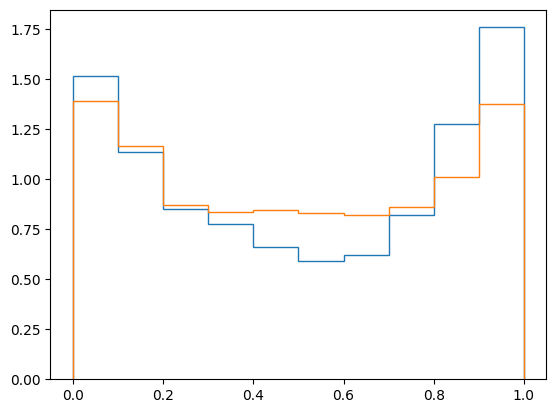

In [8]:
plt.hist(df['NAWP'], density=True, histtype='step')
plt.hist(df['ECR'], density=True, histtype='step')
plt.show()

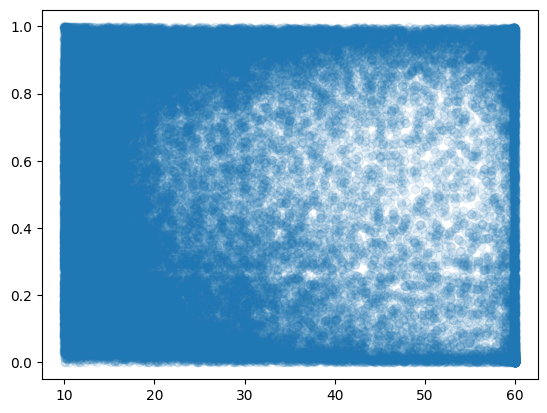

In [9]:
plt.scatter(df['Video_len'], df['NAWP'], alpha=0.1)
plt.show()

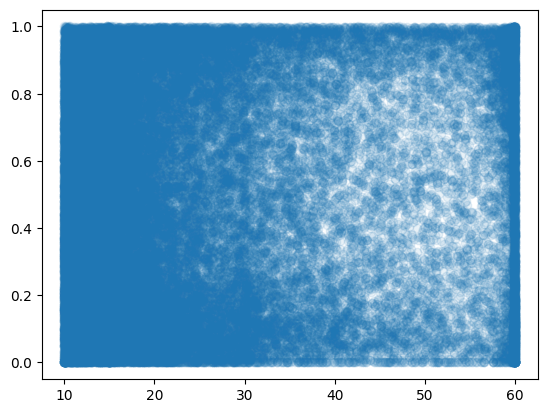

In [10]:
plt.scatter(df['Video_len'], df['ECR'], alpha=0.1)
plt.show()

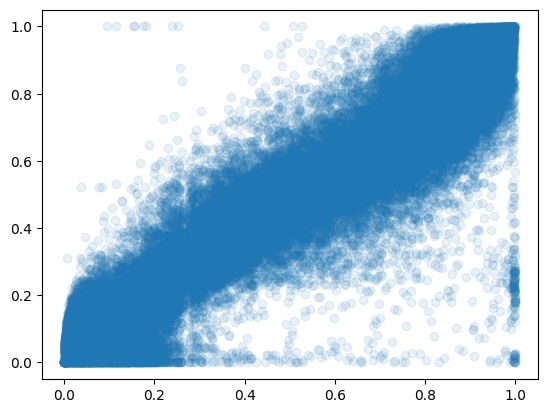

In [11]:
plt.scatter(df['NAWP'], df['ECR'], alpha=0.1)
plt.show()

In [12]:
df.drop(columns=["Link", "Video"]).to_csv("prepped_df.csv")

# Split videos to segments

In [13]:
# sample_video = df.sample(1)['Video'].values[0]
# print(sample_video)

# scene_list = detect(sample_video, AdaptiveDetector())
# split_video_ffmpeg(sample_video, scene_list, "temp")
# scene_list

In [14]:
# segments_dict = {
#     "Id": [],
#     "Scene_id": [],
#     "Start": [],
#     "End": []
# }

# vid_count = 600 # start point from previous progress
# df_sub = df.iloc[vid_count:]
# for id, row in tqdm(df.iterrows(), total=len(df), desc="Processing videos"):
#     video_path = row['Video']
#     scene_list = detect(video_path, AdaptiveDetector())
#     # split_video_ffmpeg(video_path, scene_list, segment_path) # use this to save the actual segments
    
#     # save the scene list in time format
#     if len(scene_list) == 0:
#         segments_dict["Id"].append(id)
#         segments_dict["Scene_id"].append(0)
#         segments_dict["Start"].append(0)
#         segments_dict["End"].append(row['Video_len'])
#     else:
#         for i, scene in enumerate(scene_list):
#             segments_dict["Id"].append(id)
#             segments_dict["Scene_id"].append(i)
#             segments_dict["Start"].append(scene[0].get_seconds())
#             segments_dict["End"].append(scene[1].get_seconds())

#     vid_count += 1
#     if vid_count % 100 == 0:
#         pd.DataFrame(segments_dict).to_csv(f"prepare/video_segments_{vid_count - 100}_{vid_count}.csv", index=False)
        
#         # reset the segments to prevent OOM
#         segments_dict = {
#             "Id": [],
#             "Scene_id": [],
#             "Start": [],
#             "End": []
#         }

# Convert video and audio to tensors

In [15]:
video_path = df.sample(1)['Video'].values[0]
video_path

'/mnt/d/Thesis/Data/SnapUGC/Train/7151ad470af22a196efb9ec2db832608.mp4'

Original Video path: /mnt/d/Thesis/Data/SnapUGC/Train/7151ad470af22a196efb9ec2db832608.mp4
Video shape: (182, 224, 128, 3)
Audio shape: (584772,)


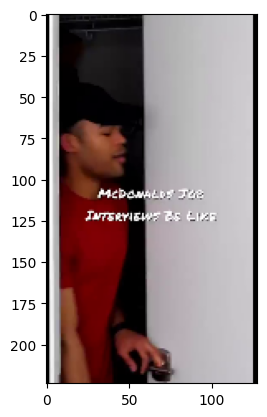

In [16]:
import cv2
import numpy as np
import ffmpeg
from pydub import AudioSegment
import io

def video_audio_to_array(video_path, 
                         target_height=var.TARGET_FRAME_SIZE[0], target_width=var.TARGET_FRAME_SIZE[1], target_fps=var.VIDEO_FPS, 
                         target_sample_rate=var.AUDIO_FPS):
    """Extracts video frames and audio from an mp4 file, ensuring fixed FPS, resizing frames with padding,
       and downsampling audio to a lower sample rate while preserving speech.

    Args:
        video_path (str): Path to the video file.
        target_height (int): Target video frame height.
        target_width (int): Target video frame width.
        target_fps (int): Target frame rate.
        target_sample_rate (int): Target audio sample rate (default 16 kHz for speech).

    Returns:
        video_array (np.ndarray): (num_frames, target_height, target_width, 3), dtype=np.uint8.
        audio_array (np.ndarray): (num_samples,) or (num_samples, 2) for stereo, dtype=np.int16.
        sample_rate (int): Audio sample rate in Hz.
    """
    # ---- Extract Video Frames with Fixed FPS ----
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = original_fps / target_fps  # Frame selection interval

    frames = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % round(frame_interval) == 0:  # Select frames to match target FPS
            h, w, _ = frame.shape

            # Resize with padding to maintain aspect ratio
            scale = min(target_width / w, target_height / h)
            new_w, new_h = int(w * scale), int(h * scale)
            resized_frame = cv2.resize(frame, (new_w, new_h))

            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            # Pad to fixed size
            padded_frame = np.zeros((target_height, target_width, 3), dtype=np.uint8)
            pad_top = (target_height - new_h) // 2
            pad_left = (target_width - new_w) // 2
            padded_frame[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_frame

            frames.append(padded_frame)  

        frame_idx += 1

    cap.release()
    video_array = np.array(frames, dtype=np.uint8)

    # ---- Extract and Downsample Audio ----
    out, _ = (
        ffmpeg.input(video_path)
        .output("pipe:", format="wav", 
                ar=target_sample_rate, # Resample to target sample rate
                ac=1)               # Mono audio
        .run(capture_stdout=True, capture_stderr=True)
    )

    audio = AudioSegment.from_file(io.BytesIO(out), format="wav")
    samples = np.array(audio.get_array_of_samples(), dtype=np.int16)

    return video_array, samples # sh

# Example usage
video_array, audio_array, = video_audio_to_array(video_path)

print(f"Original Video path: {video_path}") 
print(f"Video shape: {video_array.shape}")  # (num_frames, target_height, target_width, 3)
print(f"Audio shape: {audio_array.shape}")  # (num_samples,)



plt.imshow(video_array[0])
plt.show()

# Note: not works for WSL
# import sounddevice as sd
# audio_samples = audio_samples / np.max(np.abs(audio_samples))
# print("Playing audio...")
# sd.play(audio_samples, samplerate=AUDIO_FPS)
# sd.wait()

In [17]:
df

,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set,ECR,NAWP,Video
Id,,,,,,,,,,
5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/5902367b4d7d4...
9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/9be2d4d5e8d4b...
1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/1d5a6586d42b5...
1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/1e9b26ba367a8...
e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train,0.000000,0.000000,/mnt/d/Thesis/Data/SnapUGC/Train/e86dbca986923...
...,...,...,...,...,...,...,...,...,...,...
58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,https://cf-st.sc-cdn.net/d/YqSwFUx26BXDuj0ZORl...,test,0.269961,0.999466,/mnt/d/Thesis/Data/SnapUGC/Test/58ec27987a3590...
26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test,0.371187,0.999596,/mnt/d/Thesis/Data/SnapUGC/Test/26e446b86f92fa...
72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test,0.275392,0.999893,/mnt/d/Thesis/Data/SnapUGC/Test/72ae9bac4dd52c...


# Save tensors

In [18]:
import numpy as np
import wave

def save_video_audio(video_array, audio_array, sample_rate, video_file, audio_file):
    np.savez_compressed(video_file, video=video_array)
    
    # Save audio as WAV (16-bit PCM, uncompressed for fast loading)
    with wave.open(audio_file, 'w') as wf:
        wf.setnchannels(1)  # Mono
        wf.setsampwidth(2)  # 16-bit PCM (2 bytes per sample)
        wf.setframerate(sample_rate)
        wf.writeframes(audio_array.tobytes())

# Example usage
save_video_audio(video_array, audio_array, var.AUDIO_FPS, video_file="temp/video.npz", audio_file="temp/audio.wav")

# Process on multiple videos

In [19]:
import concurrent.futures

os.makedirs(var.TO_PATH + "/train", exist_ok=True)
os.makedirs(var.TO_PATH + "/test", exist_ok=True)


def process_video(row):
    """Processes a single video file: extracts frames & audio, saves them."""
    video_pathname = f"{var.TO_PATH}/{row['Set']}/{row.name}.npz"
    audio_pathname = f"{var.TO_PATH}/{row['Set']}/{row.name}.wav"
    if os.path.exists(video_pathname) and os.path.exists(audio_pathname):
        return "existed"
    try:
        # convert to array
        video_array, audio_array = video_audio_to_array(row['Video'])
        
        # save to files
        save_video_audio(video_array, audio_array, var.AUDIO_FPS,
                         video_file=video_pathname,
                         audio_file=audio_pathname)

        return row.name  # Return processed video ID
    except Exception as e:
        return f"Error processing {row.name}: {e}"

def main_process(df, max_workers=4):
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_video, row) for _, row in df.iterrows()]
        # Wrap `futures` in tqdm for a progress bar
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Videos"):
            future.result()  # Ensure exceptions are caught
    print("Processing completed!")


In [20]:
test_small_df = df[df['Set'] == 'test'].sample(frac=var.SUB_FRACTION)
main_process(test_small_df)

Processing Videos: 100%|██████████| 693/693 [06:11<00:00,  1.87it/s]

Processing completed!


In [21]:
train_small_df = df[df['Set'] == 'train'].sample(frac=var.SUB_FRACTION)
main_process(train_small_df)

Processing Videos: 100%|██████████| 5090/5090 [45:42<00:00,  1.86it/s]  

Processing completed!


In [ ]:
# def load_video_audio(video_file, audio_file):
#     video_data = np.load(video_file)
#     video_array = video_data["video"]

#     with wave.open(audio_file, 'r') as wf:
#         sample_rate = wf.getframerate()
#         audio_array = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)

#     return video_array, audio_array